Imports

In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import pandas as pd

In [ ]:
! wget http://dl.deepnn.ir/Diverse_hand_gesture_dataset.zip

--2024-11-02 13:14:28--  http://dl.deepnn.ir/Diverse_hand_gesture_dataset.zip
Resolving dl.deepnn.ir (dl.deepnn.ir)... 188.40.164.149
Connecting to dl.deepnn.ir (dl.deepnn.ir)|188.40.164.149|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1088794071 (1.0G) [application/zip]
Saving to: ‘Diverse_hand_gesture_dataset.zip’

Diverse_hand_gestur 100%[===================>]   1.01G  21.5MB/s    in 50s     

2024-11-02 13:15:19 (20.7 MB/s) - ‘Diverse_hand_gesture_dataset.zip’ saved [1088794071/1088794071]



In [ ]:
!unzip -qq Diverse_hand_gesture_dataset.zip

Load the data

In [ ]:
folder_path = '/content/train'

files_with_numbers = []

for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)

        label, _, _, _, _ = pd.read_csv(file_path, sep=' ')

        if label in ['0', '1']:
            files_with_numbers.append(file_path.replace('.txt', '.png'))

print(len(files_with_numbers))


1600


In [ ]:
list_d = tf.data.Dataset.from_tensor_slices(files_with_numbers)

In [ ]:
val_size = int(image_count * 0.1)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

In [ ]:
def decode_img(img):
    img = tf.io.decode_png(img, channels=3)
    return tf.image.resize(img, [256, 256])

In [ ]:
def process_path(file_path):
    label = tf.io.read_file(file_path)
    label = decode_img(label) / 255.0
    img = label[:,:,0] * 0.2989 + label[:,:,1] * 0.5870 + label[:,:,2] * 0.1140
    img = img[..., tf.newaxis]
    return img, label

In [ ]:
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.batch(64)
val_ds = val_ds.batch(64)

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Visualize the data

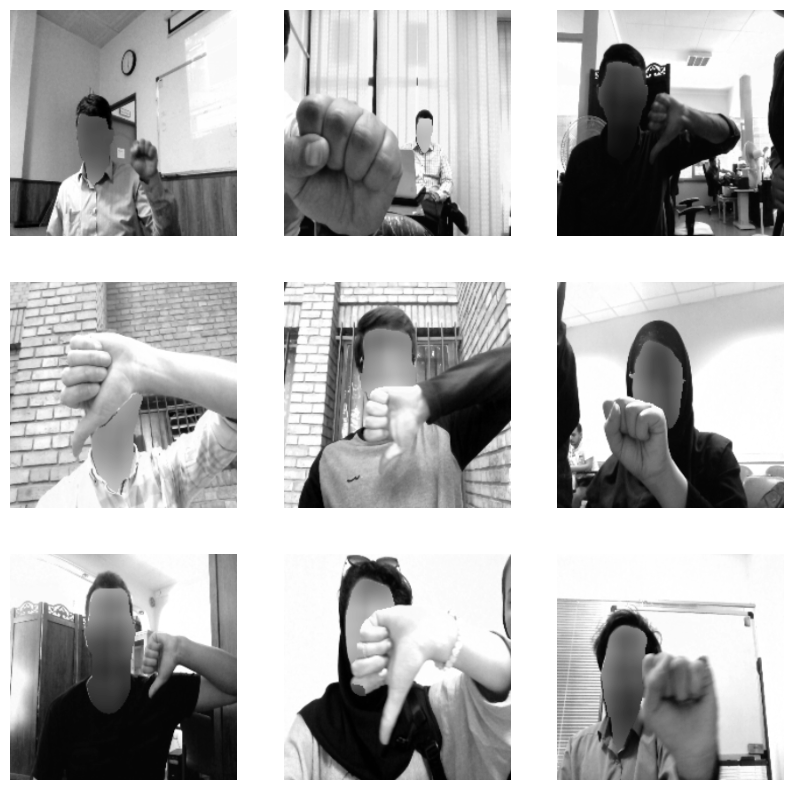

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow((image_batch[i].numpy()*255).astype('uint8'), cmap='gray')
  plt.axis("off")

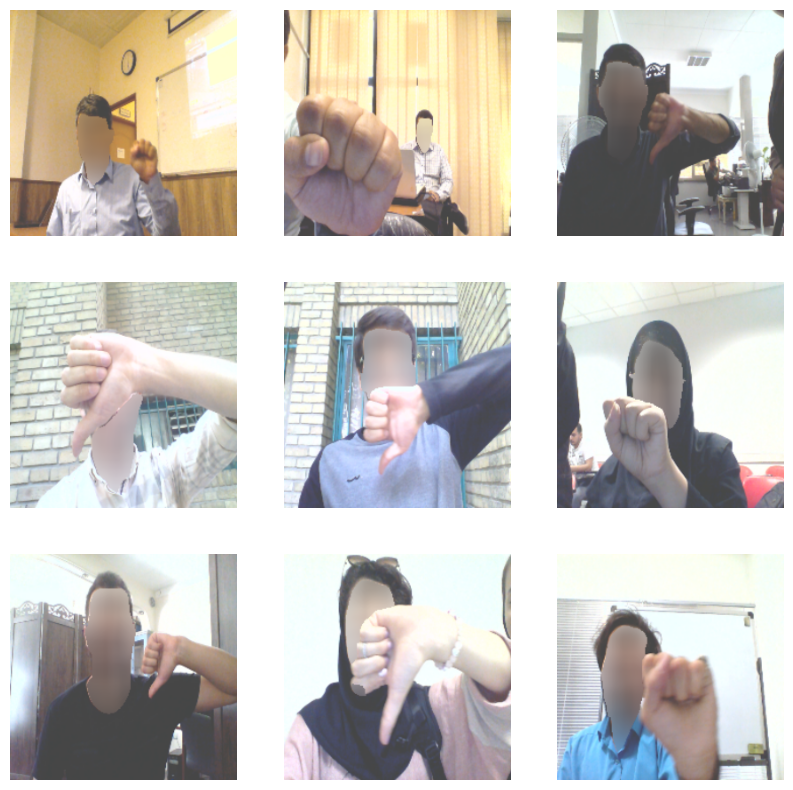

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow((label_batch[i].numpy()*255).astype('uint8'))
  plt.axis("off")

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

Generator

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), 
    downsample(128, 4),
    downsample(256, 4), 
    downsample(512, 4), 
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4), 
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  
    upsample(512, 4, apply_dropout=True),  
    upsample(512, 4, apply_dropout=True),  
    upsample(512, 4), 
    upsample(256, 4), 
    upsample(128, 4),
    upsample(64, 4), 
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') 

  x = inputs
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

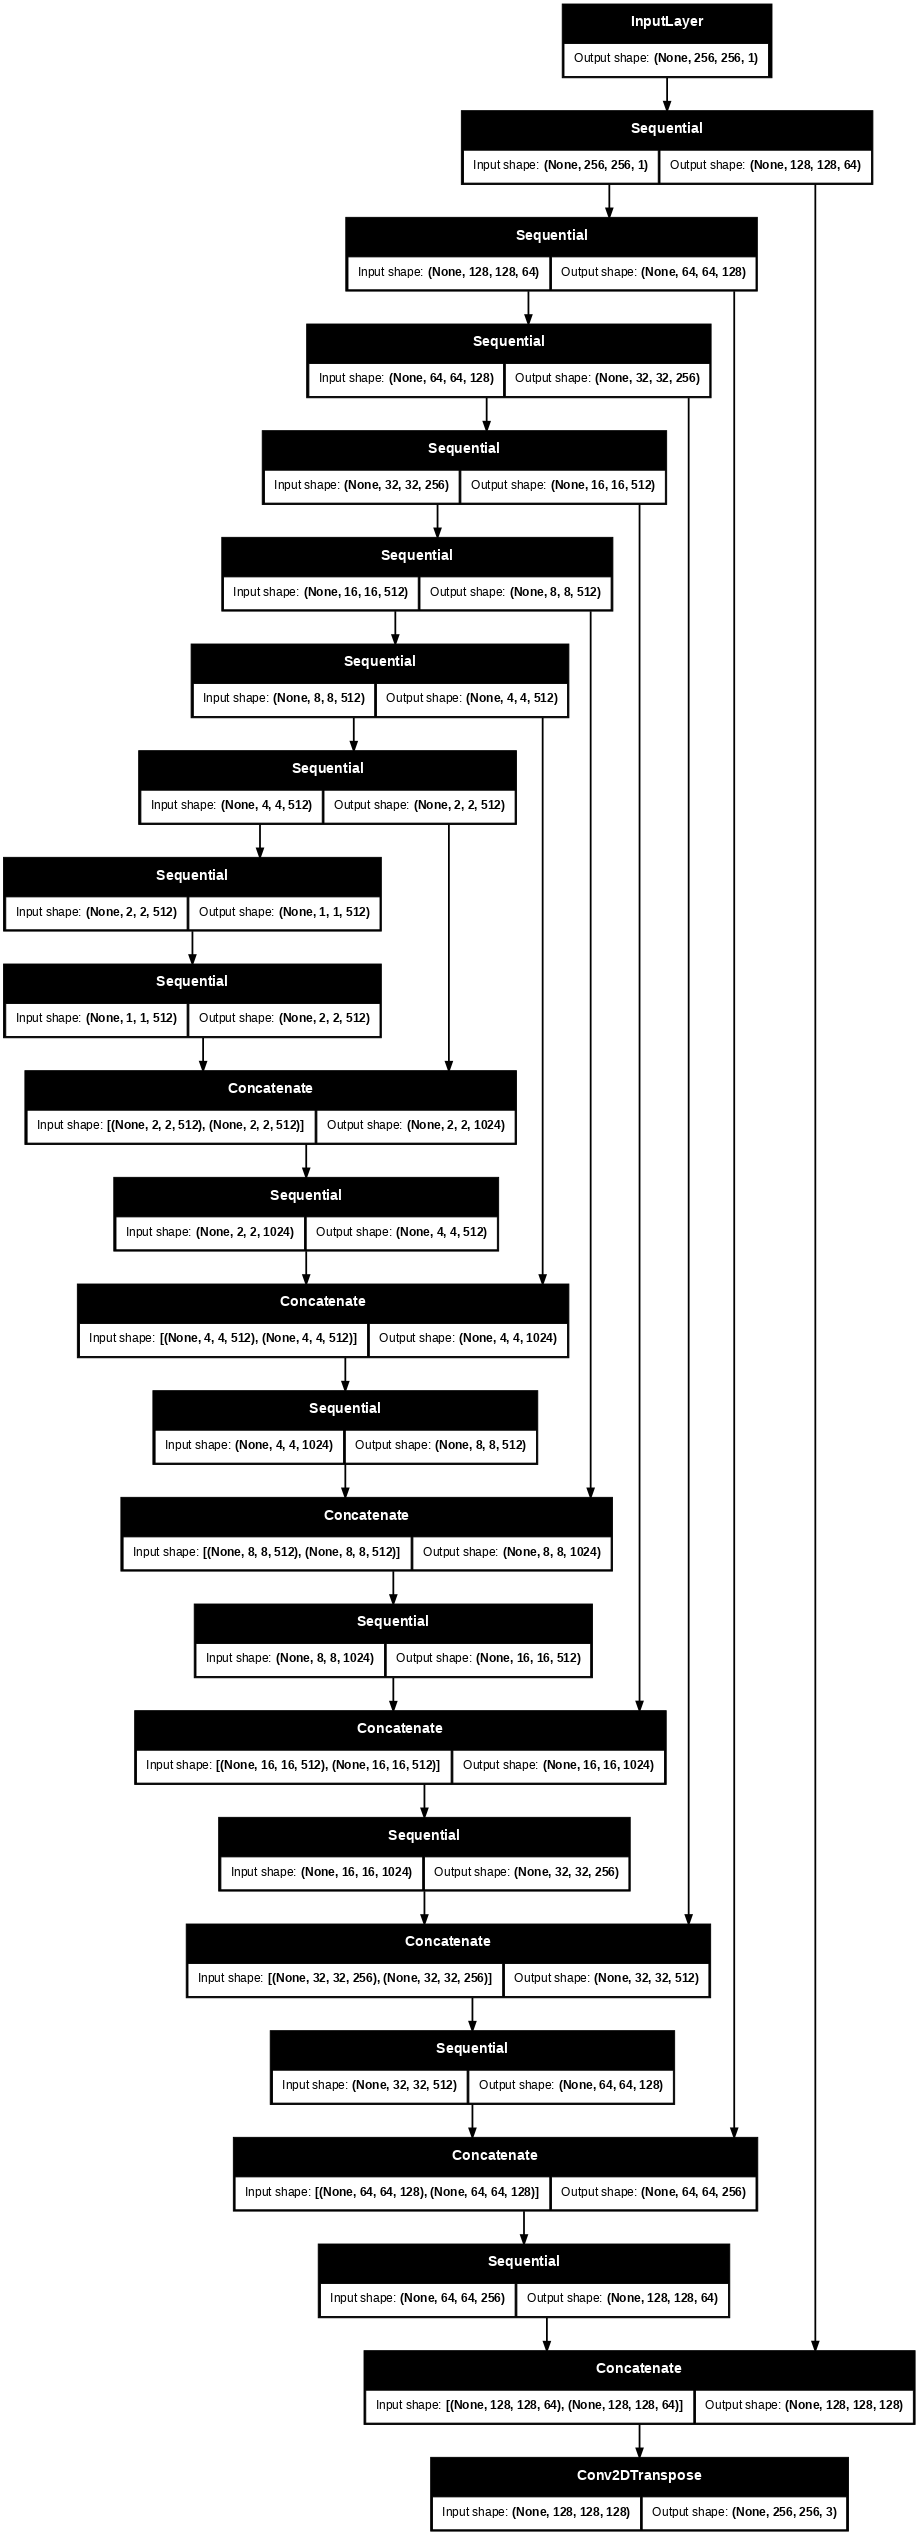

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

Discriminator

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  

  down1 = downsample(64, 4, False)(x)  
  down2 = downsample(128, 4)(down1) 
  down3 = downsample(256, 4)(down2)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) 

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) 

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) 

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

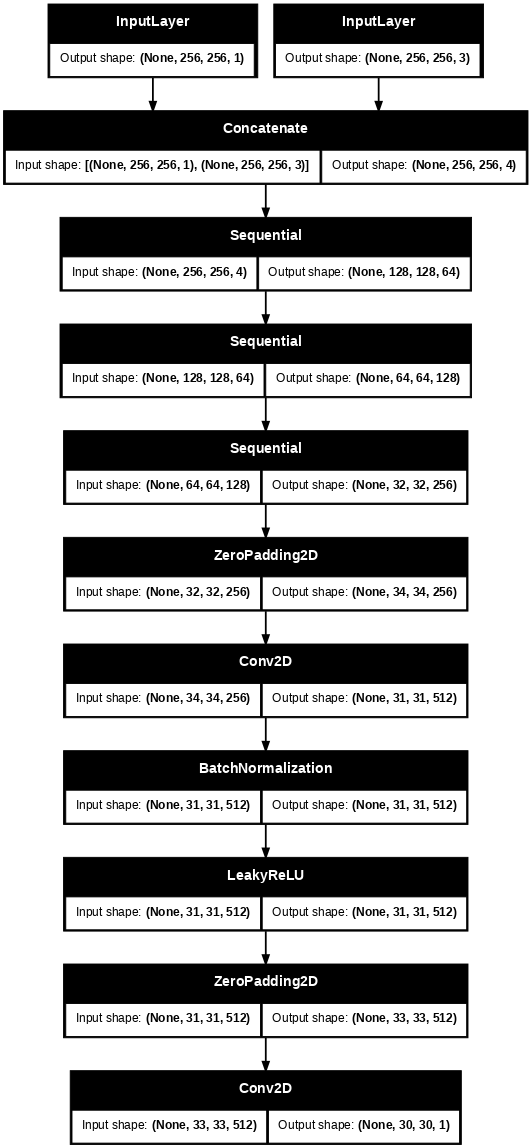

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[3], tar[3], prediction[3]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Training

In [ ]:
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
import time

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

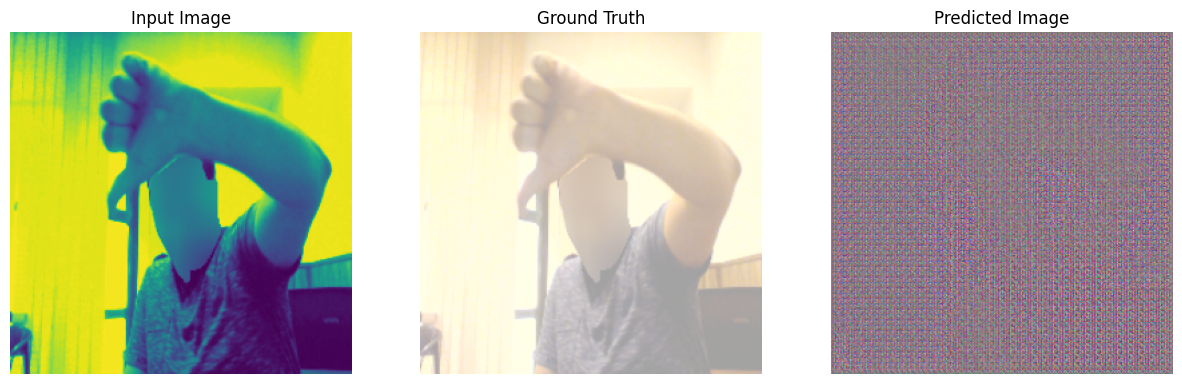

Step: 0k
....................................................................................................Time taken for 1000 steps: 3137.84 sec



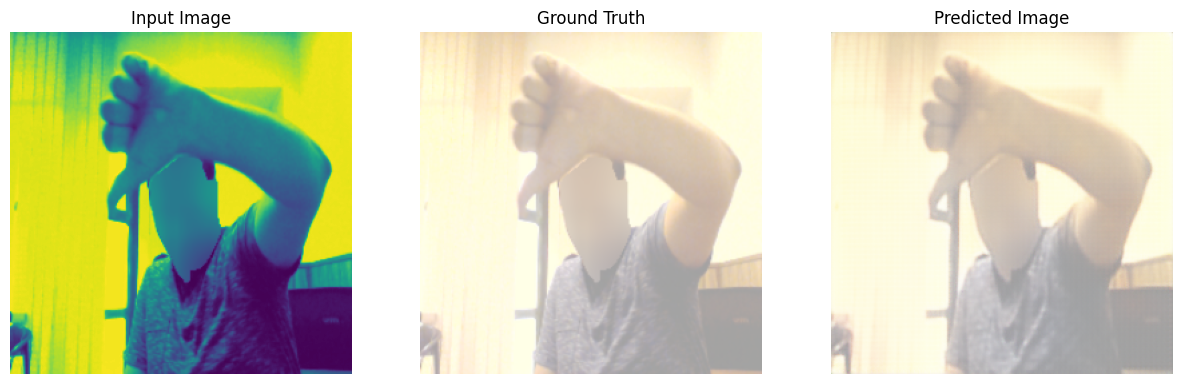

Step: 1k
....

KeyboardInterrupt: 

In [ ]:
fit(train_ds, val_ds, steps=20000)

The training process was stopped due to good results and high computational volume.

In [ ]:
generator.save_weights('model.weights.h5')

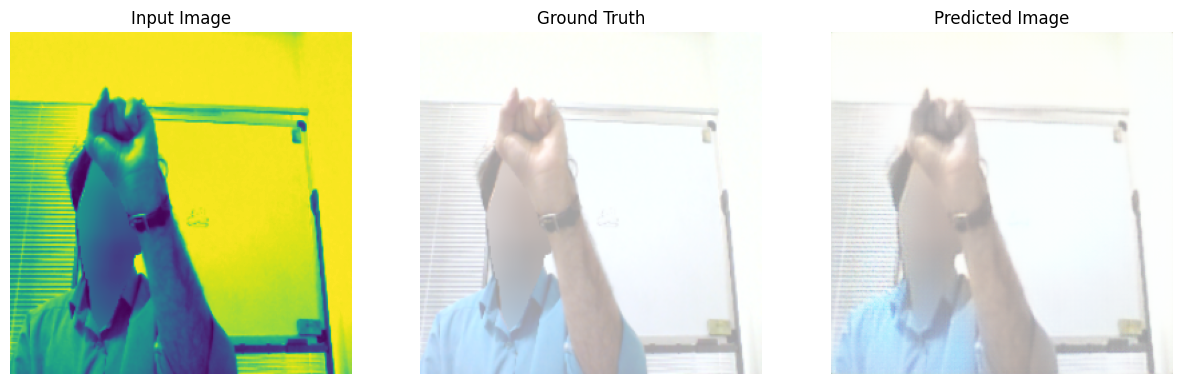

In [ ]:
for example_input, example_target in val_ds.take(1):
  generate_images(generator, example_input, example_target)

As can be seen from the results, this model performed well on a number of classes in this training dataset, and in the image above, only the shirt's stain section was not properly colored.